In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Softmax, Dropout, GRU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
import tensorflow as tf
import os
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score

In [150]:
sequences = np.load('seq_labels/sequences_pose_all.npy')
labels = np.load('seq_labels/labels_pose_all.npy')
# actions = np.array(['goodbye', 'hi', 'you', 'me', 'thankyou', 'goodmorning'])
# actions = np.array(['come', 'good', 'happy', 'home', 'iloveyou', 'sorry'])
actions = np.array(['come', 'good', 'goodbye', 'goodmorning', 'happy', 'hi', 'home', 'iloveyou', 'me', 'sorry', 'thankyou', 'you'])

In [151]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [152]:
xtrain, xrem, ytrain, yrem = train_test_split(X, y, test_size=0.3)

xval, xtest, yval, ytest = train_test_split(xrem, yrem, test_size=0.5)

# xtrain = np.load('data_all/xtrain.npy')
# ytrain = np.load('data_all/ytrain.npy')
# xval = np.load('data_all/xval.npy')
# yval = np.load('data_all/yval.npy')
# xtest = np.load('data_all/xtest.npy')
# ytest = np.load('data_all/ytest.npy')

# xtrain = np.load('data_2/xtrain.npy')
# ytrain = np.load('data_2/ytrain.npy')
# xval = np.load('data_2/xval.npy')
# yval = np.load('data_2/yval.npy')
# xtest = np.load('data_2/xtest.npy')
# ytest = np.load('data_2/ytest.npy')

# xtrain = np.load('data_1/xtrain.npy')
# ytrain = np.load('data_1/ytrain.npy')
# xval = np.load('data_1/xval.npy')
# yval = np.load('data_1/yval.npy')
# xtest = np.load('data_1/xtest.npy')
# ytest = np.load('data_1/ytest.npy')

# xtrain = np.load('data_all_a/xtrain.npy')
# ytrain = np.load('data_all_a/ytrain.npy')
# xval = np.load('data_all_a/xval.npy')
# yval = np.load('data_all_a/yval.npy')
# xtest = np.load('data_all_a/xtest.npy')
# ytest = np.load('data_all_a/ytest.npy')

In [153]:
# np.save('data_all_a/xtrain.npy',xtrain)
# np.save('data_all_a/xval.npy',xval)
# np.save('data_all_a/xtest.npy',xtest)
# np.save('data_all_a/ytrain.npy',ytrain)
# np.save('data_all_a/yval.npy',yval)
# np.save('data_all_a/ytest.npy',ytest)

In [159]:
file_name = 'all_gru_help_meeee'

In [160]:
# np.random.seed(42)
tf.random.set_seed(42)
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
checkpoint_callback = ModelCheckpoint(f'islr_{file_name}.h5', monitor='val_categorical_accuracy', save_best_only=True)
history = History()

In [161]:
callback = EarlyStopping(monitor='val_categorical_accuracy', patience=7, start_from_epoch = 70)

In [162]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(30, 258)))
# model.add(LeakyReLU())
# model.add(Dropout(0.4))
# model.add(LSTM(128, return_sequences=True))
# model.add(LeakyReLU())
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU())
# model.add(Dense(64))
# model.add(LeakyReLU())
# model.add(Dense(32))
# model.add(LeakyReLU())
# model.add(Dense(actions.shape[0]))
# model.add(Softmax())

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(30, 258)))
model.add(LeakyReLU())
model.add(Dropout(0.4))
model.add(GRU(128, return_sequences=True))
model.add(LeakyReLU())
model.add(GRU(64, return_sequences=False))
model.add(LeakyReLU())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dense(actions.shape[0]))
model.add(Softmax())

In [163]:
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [164]:
history = model.fit(xtrain, ytrain, epochs=100, callbacks=[tb_callback, callback, history, checkpoint_callback], batch_size=32, validation_data=(xval, yval))

Epoch 1/100
36/36 [==============================] - 16s 205ms/step - loss: 2.4438 - categorical_accuracy: 0.1247 - val_loss: 2.2588 - val_categorical_accuracy: 0.1585
Epoch 2/100
36/36 [==============================] - 4s 117ms/step - loss: 2.1089 - categorical_accuracy: 0.1752 - val_loss: 1.9580 - val_categorical_accuracy: 0.2114
Epoch 3/100
36/36 [==============================] - 5s 138ms/step - loss: 1.8583 - categorical_accuracy: 0.2694 - val_loss: 1.6633 - val_categorical_accuracy: 0.2642
Epoch 4/100
36/36 [==============================] - 4s 112ms/step - loss: 1.6950 - categorical_accuracy: 0.3156 - val_loss: 1.5420 - val_categorical_accuracy: 0.3740
Epoch 5/100
36/36 [==============================] - 5s 150ms/step - loss: 1.4983 - categorical_accuracy: 0.3871 - val_loss: 1.3721 - val_categorical_accuracy: 0.4512
Epoch 6/100
36/36 [==============================] - 4s 117ms/step - loss: 1.3765 - categorical_accuracy: 0.4263 - val_loss: 1.2985 - val_categorical_accuracy: 0.47

In [171]:
model.load_weights(f'islr_{file_name}.h5')
# model.load_weights(f'islr_all_gru_6.h5')

In [172]:
train_loss, train_acc = model.evaluate(xtrain, ytrain)
print('Train accuracy: ', train_acc)
print('Train loss: ', train_loss)

36/36 [==============================] - 1s 28ms/step - loss: 0.0739 - categorical_accuracy: 0.9782
Train accuracy:  0.9782040119171143
Train loss:  0.07393297553062439


In [173]:
val_loss, val_acc = model.evaluate(xval, yval)
print('Val accuracy: ', val_acc)
print('Val loss: ', val_loss)

8/8 [==============================] - 0s 27ms/step - loss: 0.1833 - categorical_accuracy: 0.9593
Val accuracy:  0.9593495726585388
Val loss:  0.1833450198173523


In [174]:
test_loss, test_acc = model.evaluate(xtest, ytest)

8/8 [==============================] - 0s 28ms/step - loss: 0.2713 - categorical_accuracy: 0.9268


In [168]:
print('Test accuracy: ', test_acc)
print('Test loss: ', test_loss)

Test accuracy:  0.922764241695404
Test loss:  0.2987249791622162


In [169]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 30, 64)            62208     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 30, 64)            0         
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_19 (GRU)                (None, 30, 128)           74496     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 30, 128)           0         
                                                                 
 gru_20 (GRU)                (None, 64)                37248     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 64)               

In [170]:
model.save(f'islr_{file_name}a.h5')

In [114]:
ypred = model.predict(xtest)

8/8 [==============================] - 9s 59ms/step


In [115]:
ytrue = np.argmax(ytest, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [116]:
cm = confusion_matrix(ytrue,ypred)

In [117]:
cm

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 28,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 16,  0,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 17,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 17,  0,  5,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17]])

In [118]:
cm_df = pd.DataFrame(cm,
                     index = actions, 
                     columns = actions)

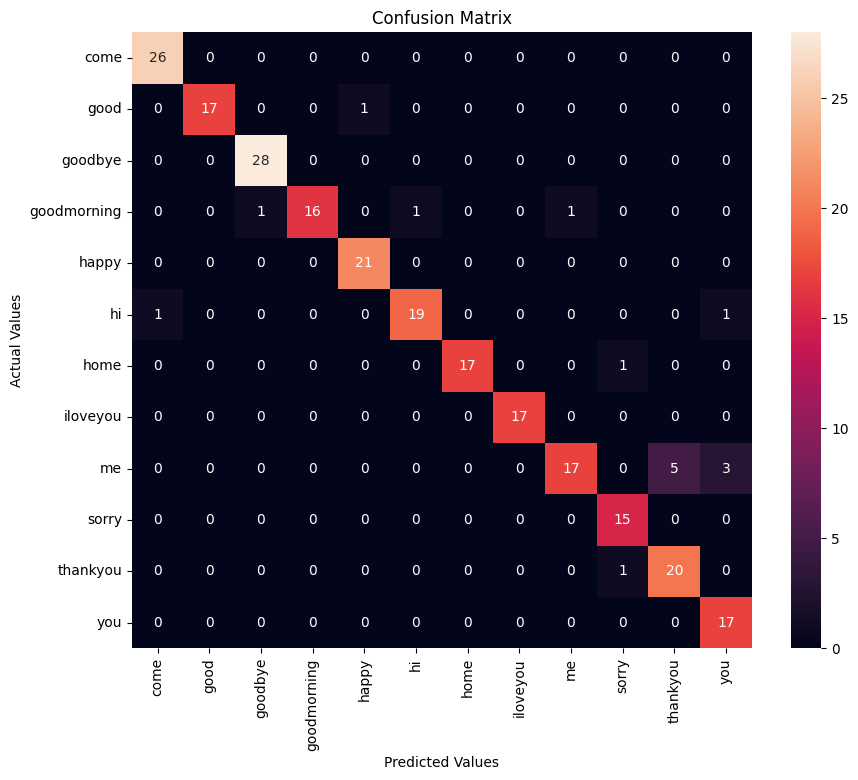

In [119]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig(f'graphs/conf_matrix_{file_name}.png')
plt.show()

In [120]:
mcm1 = multilabel_confusion_matrix(ytrue, ypred)
print(mcm1)

[[[219   1]
  [  0  26]]

 [[228   0]
  [  1  17]]

 [[217   1]
  [  0  28]]

 [[227   0]
  [  3  16]]

 [[224   1]
  [  0  21]]

 [[224   1]
  [  2  19]]

 [[228   0]
  [  1  17]]

 [[229   0]
  [  0  17]]

 [[220   1]
  [  8  17]]

 [[229   2]
  [  0  15]]

 [[220   5]
  [  1  20]]

 [[225   4]
  [  0  17]]]


In [122]:
acc = accuracy_score(ytrue, ypred)
rec_w = recall_score(ytrue, ypred, average = 'weighted')
rec_n = recall_score(ytrue, ypred, average = None)
pre_w = precision_score(ytrue, ypred, average = 'weighted')
pre_n = precision_score(ytrue, ypred, average = None)
f1_w = f1_score(ytrue, ypred, average = 'weighted')
f1_n = f1_score(ytrue, ypred, average = None)


print('Accuracy: ', round(acc, 3))
print('Recall (weighted): ', round(rec_w, 3))
print('Precision (weighted): ', round(pre_w, 3))
print('F1 score (weighted): ', round(f1_w, 3))

print('Recall : ', [round(x, 3) for x in rec_n])
print('Precision : ', [round(x, 3) for x in pre_n])
print('F1 score : ', [round(x, 3) for x in f1_n])


Accuracy:  0.935
Recall (weighted):  0.935
Precision (weighted):  0.941
F1 score (weighted):  0.933
Recall :  [1.0, 0.944, 1.0, 0.842, 1.0, 0.905, 0.944, 1.0, 0.68, 1.0, 0.952, 1.0]
Precision :  [0.963, 1.0, 0.966, 1.0, 0.955, 0.95, 1.0, 1.0, 0.944, 0.882, 0.8, 0.81]
F1 score :  [0.981, 0.971, 0.982, 0.914, 0.977, 0.927, 0.971, 1.0, 0.791, 0.938, 0.87, 0.895]


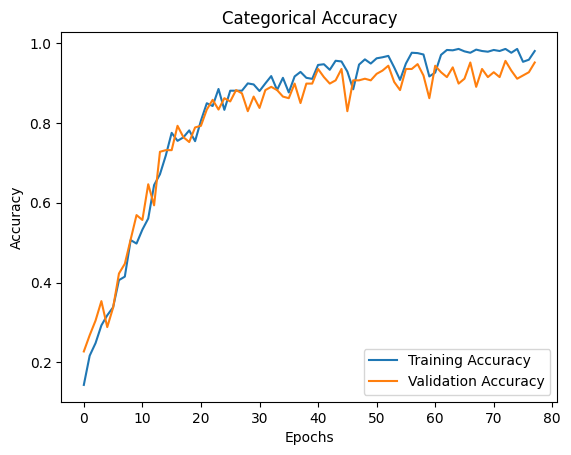

In [123]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.legend()
# plt.savefig(f'graphs/accuracy_{file_name}.png')
plt.show()

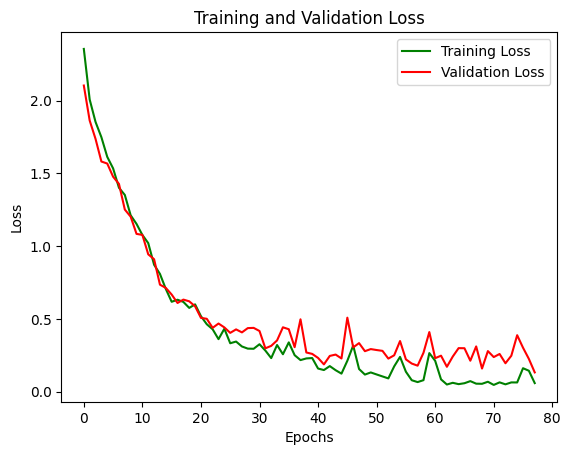

In [124]:
plt.plot(history.history['loss'], color= 'green',label='Training Loss')
plt.plot(history.history['val_loss'], color= 'red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.savefig(f'graphs/loss_{file_name}.png')
plt.show()

In [125]:
ep = len(history.history['loss'])
print('Epochs: ', ep)

Epochs:  78


In [126]:
pd.DataFrame(history.history).to_csv(f'graphs/history_{file_name}.csv')

In [127]:
history.history['val_loss']

[2.104569911956787,
 1.8637572526931763,
 1.7375614643096924,
 1.581900954246521,
 1.5680058002471924,
 1.4773410558700562,
 1.4279658794403076,
 1.2516926527023315,
 1.20244300365448,
 1.0843188762664795,
 1.0772087574005127,
 0.9437547922134399,
 0.909915566444397,
 0.7350202202796936,
 0.7127482891082764,
 0.6670671701431274,
 0.6091201901435852,
 0.6323369741439819,
 0.6204915046691895,
 0.586350679397583,
 0.5066723823547363,
 0.5002104043960571,
 0.4381822943687439,
 0.4678034782409668,
 0.44098231196403503,
 0.4035269021987915,
 0.42743781208992004,
 0.4068211615085602,
 0.43626368045806885,
 0.4378588795661926,
 0.41632577776908875,
 0.2973826825618744,
 0.3141438663005829,
 0.35165730118751526,
 0.4418450891971588,
 0.42851585149765015,
 0.30513545870780945,
 0.4968600571155548,
 0.2686057984828949,
 0.2588830888271332,
 0.2312268614768982,
 0.1867186576128006,
 0.24493595957756042,
 0.254291832447052,
 0.2274531126022339,
 0.5079020857810974,
 0.3037414848804474,
 0.333040028

In [130]:
top1_acc = np.mean(np.argmax(model.predict(xtest), axis=1) == np.argmax(ytest, axis=1))
print('Top-1 accuracy:', top1_acc)

k=3
topk_acc = np.mean(np.any(np.argsort(model.predict(xtest), axis=1)[:, -k:] == np.argmax(ytest, axis=1).reshape(-1, 1), axis=1))
print(f'Top-{k} accuracy:', topk_acc)

8/8 [==============================] - 0s 29ms/step
Top-1 accuracy: 0.9349593495934959
8/8 [==============================] - 0s 34ms/step
Top-3 accuracy: 0.9878048780487805
